In [1]:
import os

# Kaggle dataset root path
data_dir = "/kaggle/input/hc18-grand-challenge/training_set/"

# Get all file names
all_files = sorted(os.listdir(data_dir))

# Separate images and masks
image_files = [f for f in all_files if "Annotation" not in f]
mask_files = [f for f in all_files if "Annotation" in f]

# Example: print first 5 matches
for img_file in image_files[:5]:
    mask_file = img_file.replace(".png", "_Annotation.png").replace("2HC", "2HC")  # handle 2HC cases too
    if mask_file in mask_files:
        print(f"Image: {img_file}  <-->  Mask: {mask_file}")


Image: 000_HC.png  <-->  Mask: 000_HC_Annotation.png
Image: 001_HC.png  <-->  Mask: 001_HC_Annotation.png
Image: 002_HC.png  <-->  Mask: 002_HC_Annotation.png
Image: 003_HC.png  <-->  Mask: 003_HC_Annotation.png
Image: 004_HC.png  <-->  Mask: 004_HC_Annotation.png


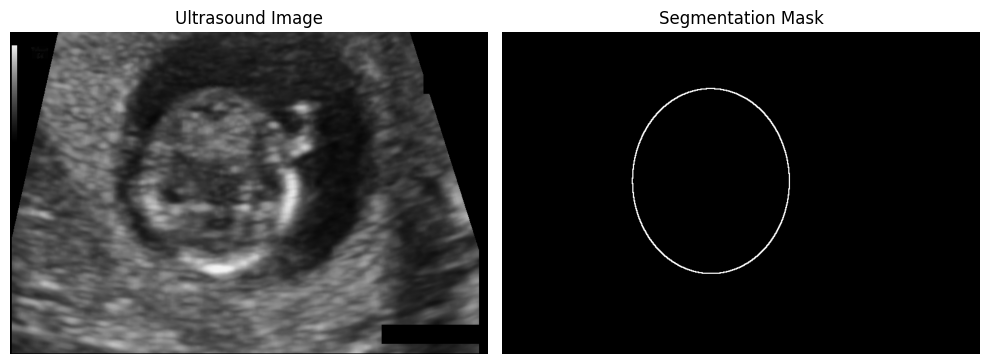

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img_name = "010_HC.png"
mask_name = "010_HC_Annotation.png"

img = Image.open(os.path.join(data_dir, img_name)).convert("RGB")
mask = Image.open(os.path.join(data_dir, mask_name)).convert("L")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Ultrasound Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class HC18Dataset(Dataset):
    def __init__(self, root_dir, image_files, transform=None, image_size=(256, 256)):
        self.root_dir = root_dir
        self.image_files = image_files
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = image_name.replace(".png", "_Annotation.png")

        image_path = os.path.join(self.root_dir, image_name)
        mask_path = os.path.join(self.root_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Resize both image and mask
        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size)

        # Convert to tensor and normalize
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        # Optional: convert mask to binary (0 or 1)
        mask = (mask > 0).float()

        return image, mask


In [3]:
from torch.utils.data import DataLoader

# Root path
data_dir = "/kaggle/input/hc18-grand-challenge/training_set/"

# Get all image files (not masks)
image_files = sorted([f for f in os.listdir(data_dir) if "_Annotation" not in f])

# Create dataset and dataloader
dataset = HC18Dataset(root_dir=data_dir, image_files=image_files)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


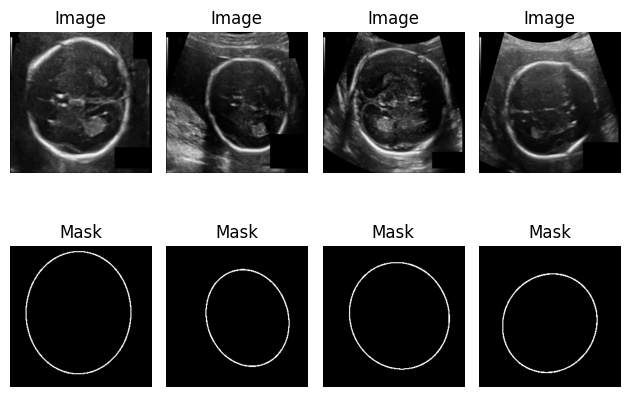

In [4]:
import matplotlib.pyplot as plt

images, masks = next(iter(dataloader))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = TF.resize(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)


In [9]:
model = UNet(in_channels=3, out_channels=1)
x = torch.randn((1, 3, 256, 256))
with torch.no_grad():
    preds = model(x)

print("Output shape:", preds.shape)


Output shape: torch.Size([1, 1, 256, 256])


# Set Up Training

In [10]:
import torch.optim as optim
import torch.nn.functional as F

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Dice Score metric
def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice.mean()
